In [1]:
# This code uses slope based extrapolation
# Ready for delivery

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os


In [2]:
def draw_lines(img, Hlines, clr, thick):
    ###
    i = 0
    a = [[0] * len(Hlines), [0] * len(Hlines)]
    for pltline in Hlines:
        for x1,y1,x2,y2 in pltline:
            a[0][i] = ((y2-y1)/(x2-x1))
            a[1][i] = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
            i = i + 1
    ###
    aPos = [i for i in a[0] if i > 0]
    aPosLen = [a[1][a[0].index(i)] for i in a[0] if i > 0]
    aNeg = [i for i in a[0] if i <= 0]
    aNegLen = [a[1][a[0].index(i)] for i in a[0] if i <= 0]
    aAveAbs = sum(list(map(abs, a[0])))/len(a[0])
    ###
    aNegX = [i for i in aNeg if abs(abs(i)-aAveAbs)<0.3]
    aNegLenX = [a[1][a[0].index(i)] for i in aNegX]
    AveNegRate = [(i-min(aNegLenX))/(max(aNegLenX)-min(aNegLenX)) for i in aNegLenX]
    aNegXRated = [i*aNegX[AveNegRate.index(i)] for i in AveNegRate]
    SlopeNeg = sum(aNegXRated)/max(1,sum(AveNegRate))
    #
    aPosX = [i for i in aPos if abs(abs(i)-aAveAbs)<0.3]
    aPosLenX = [a[1][a[0].index(i)] for i in aPosX]
    AvePosRate = [(i-min(aPosLenX))/(max(aPosLenX)-min(aPosLenX)) for i in aPosLenX]
    aPosXRated = [i*aPosX[AvePosRate.index(i)] for i in AvePosRate]
    SlopePos = sum(aPosXRated)/max(1,sum(AvePosRate))
    ###
    NegLines = [Hlines[a[0].index(i)] for i in aNegX]
    i = 0
    xyNeg = [[0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines)]
    for pltline in NegLines:
        for x1,y1,x2,y2 in pltline:
            xyNeg[0][i] = x1
            xyNeg[1][i] = x2
            xyNeg[2][i] = y1
            xyNeg[3][i] = y2
            i = i + 1
    x1Neg = sum(xyNeg[0])/max(1,len(xyNeg[0]))
    #x2Neg = sum(xyNeg[1])/len(xyNeg[0])
    y1Neg = sum(xyNeg[2])/max(1,len(xyNeg[0]))
    #y2Neg = sum(xyNeg[3])/len(xyNeg[0])
    #
    PosLines = [Hlines[a[0].index(i)] for i in aPosX]
    i = 0
    xyPos = [[0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines)]
    for pltline in PosLines:
        for x1,y1,x2,y2 in pltline:
            xyPos[0][i] = x1
            xyPos[1][i] = x2
            xyPos[2][i] = y1
            xyPos[3][i] = y2
            i = i + 1
    x1Pos = sum(xyPos[0])/max(1,len(xyPos[0]))
    #x2Pos = sum(xyPos[1])/len(xyPos[0])
    y1Pos = sum(xyPos[2])/max(1,len(xyPos[0]))
    #y2Pos = sum(xyPos[3])/len(xyPos[0])
    ###
    yMax = img.shape[0]
    if SlopeNeg == 0: SlopeNeg = 1
    if SlopePos == 0: SlopePos = 1
    XStartNeg = int(((yMax-y1Neg)/SlopeNeg)+x1Neg)
    XStartPos = int(((yMax-y1Pos)/SlopePos)+x1Pos)
    XStopNeg = int(((320-y1Neg)/SlopeNeg)+x1Neg)
    XStopPos = int(((320-y1Pos)/SlopePos)+x1Pos)
    #inpsNeg = list(range(XStartNeg, max(xyNeg[1])))
    inpsNeg = list(range(XStartNeg, XStopNeg))
    youtNeg = [SlopeNeg*(i-x1Neg) + y1Neg for i in inpsNeg]
    #inpsPos= list(range(min(xyPos[0]), XStartPos))
    inpsPos= list(range(XStopPos, XStartPos))
    youtPos = [SlopePos*(i-x1Pos) + y1Pos for i in inpsPos]
    ###
    line_image = np.copy(img)*0
    LinesNew = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
    LinesNew = [int(i) for i in LinesNew]
    cv2.line(line_image,(LinesNew[0],LinesNew[2]),(LinesNew[1],LinesNew[3]),clr,thick)
    LinesNew = [min(inpsPos),max(inpsPos),min(youtPos),max(youtPos)]
    LinesNew = [int(i) for i in LinesNew]
    cv2.line(line_image,(LinesNew[0],LinesNew[2]),(LinesNew[1],LinesNew[3]),clr,thick)
    ###
    return line_image

In [3]:
def UpdatePicture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    plt.imshow(gray, cmap='gray')
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(masked_edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(masked_edges, mask)

    # Display the image
    #plt.imshow(masked_edges, cmap='Greys_r')

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 25
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
                                
    linesx = draw_lines(image, lines, [255, 0, 0], 10)
    #plt.imshow(linesx)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combox = cv2.addWeighted(color_edges, 0.8, linesx, 1, 0) 
    #plt.imshow(combox)

    UpdatedPicture = cv2.addWeighted(image, 1, linesx, 1, 0) 
    return UpdatedPicture

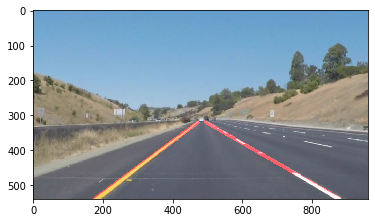

In [5]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

ResultImage = UpdatePicture(image) 
plt.imshow(ResultImage)
#plt.savefig('test_images_results/ResultImage.jpg')

In [6]:

imagex = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
ResultImage = UpdatePicture(imagex) 
cv2.imshow('image',ResultImage)
cv2.waitKey(0)
#cv2.imwrite('test_images_results/Test_gray.jpg', ResultImage)

In [10]:
#for file in os.listdir('test_images/'): image = mpimg.imread(directory+file)
#plt.imshow(image)

In [ ]:
#pip install opencv-python
#pip install moviepy

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

t: 100%|██████████| 221/221 [00:07<00:00, 38.14it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 8.18 s


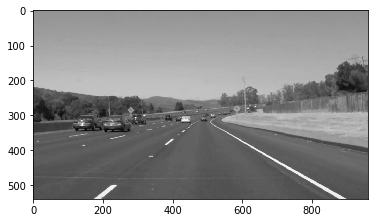

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(UpdatePicture) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
#cap = cv2.VideoCapture('test_videos/challenge.mp4')
vid_cod = cv2.VideoWriter_fourcc(*'XVID')
output = cv2.VideoWriter("video.mp4", vid_cod, 20.0, (640,480))

while(cap.isOpened()):
    ret, frame = cap.read()

    if ret:
        frame = UpdatePicture(frame)
        cv2.imshow('frame',frame)
        output.write(frame)
        #cv2.waitKey(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
output.release()
cv2.destroyAllWindows()